In [2]:
#dumb installs
%load_ext autoreload
%autoreload 2

import os
import astrophot as ap
import numpy as np
import torch
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from random import randint
from PIL import Image
%matplotlib inline

In [30]:
img = Image.open("galaxyZoo/images/100373.jpg")
img = img.convert('L')
img = np.array(img)
hdu = fits.PrimaryHDU(img)
hdu.writeto("galaxyZoo/fits_images/f_100373.fits", overwrite = True)

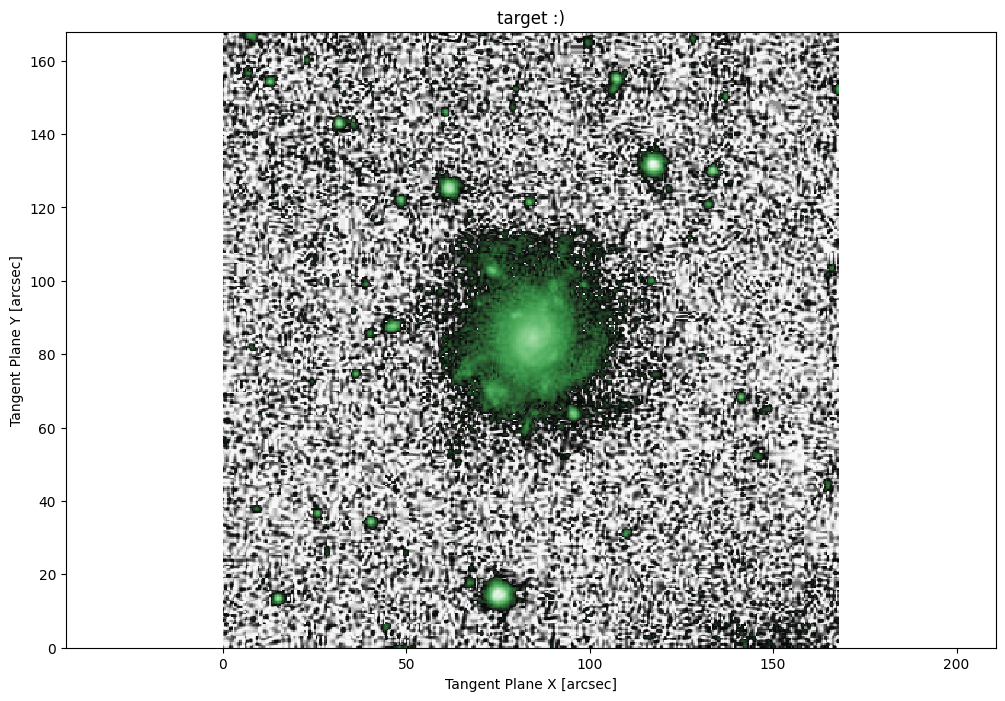

In [31]:
#making a target (basically data for the model to fit)
file = fits.open("galaxyZoo/fits_images/f_100373.fits")
target_data = np.array(file[0].data, dtype = np.float64)

# target_data = target_data.T

#target object
target = ap.image.Target_Image(
    data = target_data,
    pixelscale = 0.396, #SDSS pixel scale
    zeropoint = 22.3, #r-band in SDSS
    variance = np.ones(target_data.shape)/1e3,
    
)


# The default AstroPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas

fig, ax = plt.subplots(figsize = (12,8)) #fig is the figure, ax are the axes, figsize affects the literal size of the graph
ap.plots.target_image(fig, ax, target) #kernel crashes witg
plt.title("target :)")
plt.show()


In [32]:
model1 = ap.models.AstroPhot_Model(
    name = "model1", # every model must have a unique name
    model_type = "sersic galaxy model", # this specifies the kind of model
    #we don't need to list params because we have a target !
    target = target,
    # window = [[300, 2500],[0,2300]] #for whirlpool
)

#the model will try and guess the parameters it needs based on the target
#the galaxy has to be centered in the cutout though !
model1.initialize() # before using the model it is good practice to call initialize so the model can get itself ready

# We can print the model's current state
model1.parameters

model1 (id-140185175490624, branch node):
  center (id-140185175702208): [83.76730867562424, 83.65821678361058] +- [0.1, 0.1] [arcsec]
  q (id-140185175692752): 0.9 +- 0.03 [b/a], limits: (0.0, 1.0)
  PA (id-140185175691504): 3.0887327929267694 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
  n (id-140185175230112): 0.801984559039088 +- 0.05 [none], limits: (0.36, 8.0)
  Re (id-140185175230160): 14.258599333779753 +- 0.24700633151646104 [arcsec], limits: (0.0, None)
  Ie (id-140185254916448): 2.3581912311364723 +- 0.030218091987919075 [log10(flux/arcsec^2)]

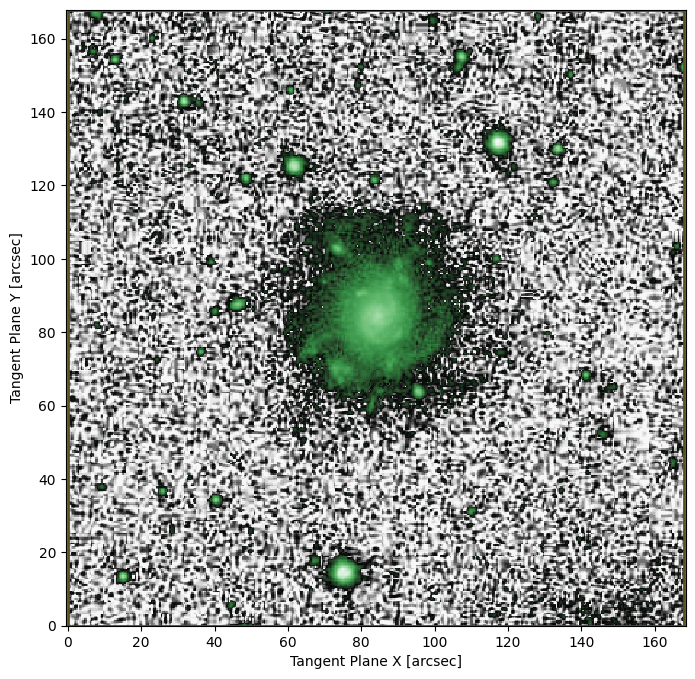

In [33]:
# We can plot the "model window" to show us what part of the image will be analyzed by that model
fig6, ax6 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig6, ax6, model1.target)
ap.plots.model_window(fig6, ax6, model1)
plt.show()

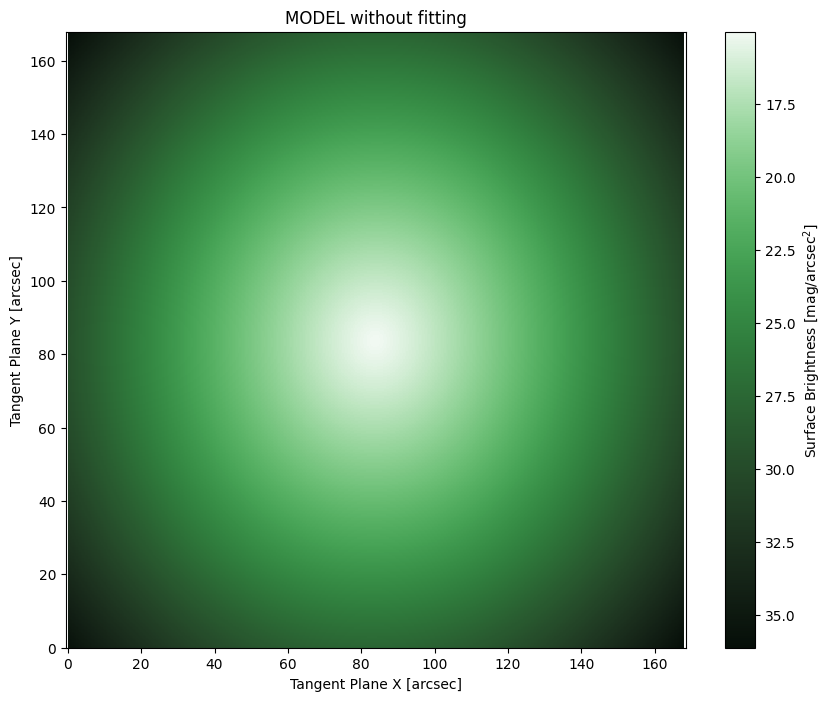

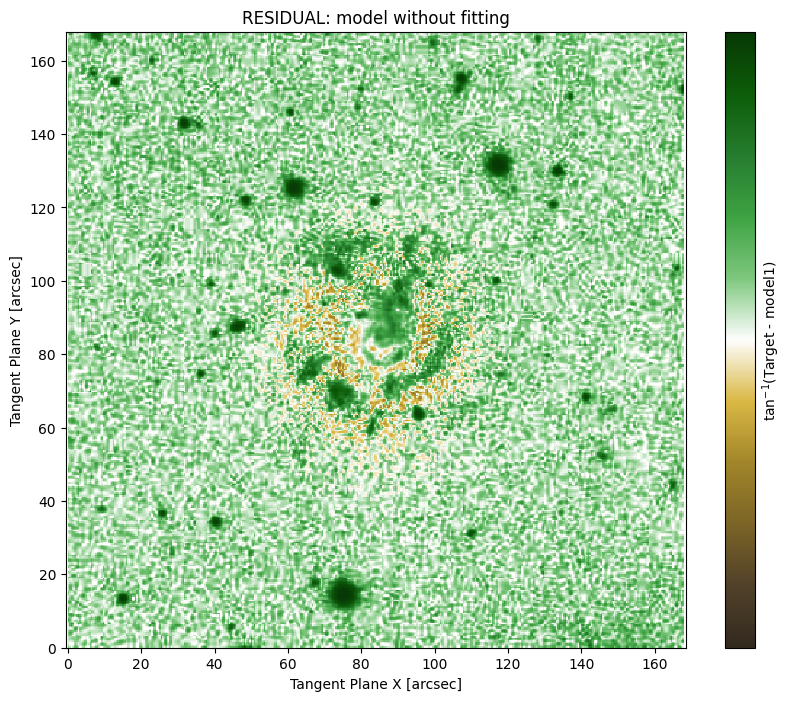

In [34]:
fig, ax = plt.subplots(figsize = (10,8))
ap.plots.model_image(fig, ax, model1,) #cmap levels makes - levels :D
plt.title("MODEL without fitting")
plt.show()

fig1, ax1 = plt.subplots(figsize = (10,8))
ap.plots.residual_image(fig1, ax1, model1)
plt.title("RESIDUAL: model without fitting") #green is target, yellow is model
plt.show()

In [35]:
#using the LM optimiser (same one used at Western so...)

# Fit the parameters
result = ap.fit.lm.LM(model1, verbose = 0).fit() #verbose is 0 by default, the higher, the more detailed output

# Check that a minimum was found
print(result.message)

# See the minimum chi^2 value
print(f"min chi2: {result.res_loss()}")

# Update parameter uncertainties
result.update_uncertainty()

# Extract multivariate Gaussian of uncertainties
mu = result.res()
cov = result.covariance_matrix

success
min chi2: 82023.76351460675


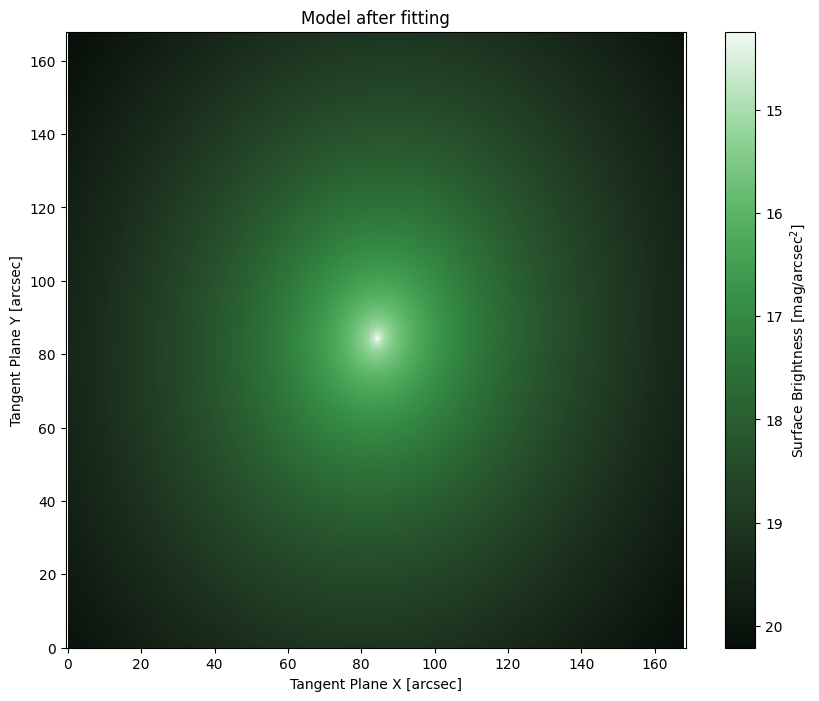

In [36]:
# plot the fit and residual fit SIDE BY SIDE
fig2, ax2 = plt.subplots(figsize = (10,8))
ap.plots.model_image(fig2, ax2, model1, )
plt.title("Model after fitting")
plt.show()

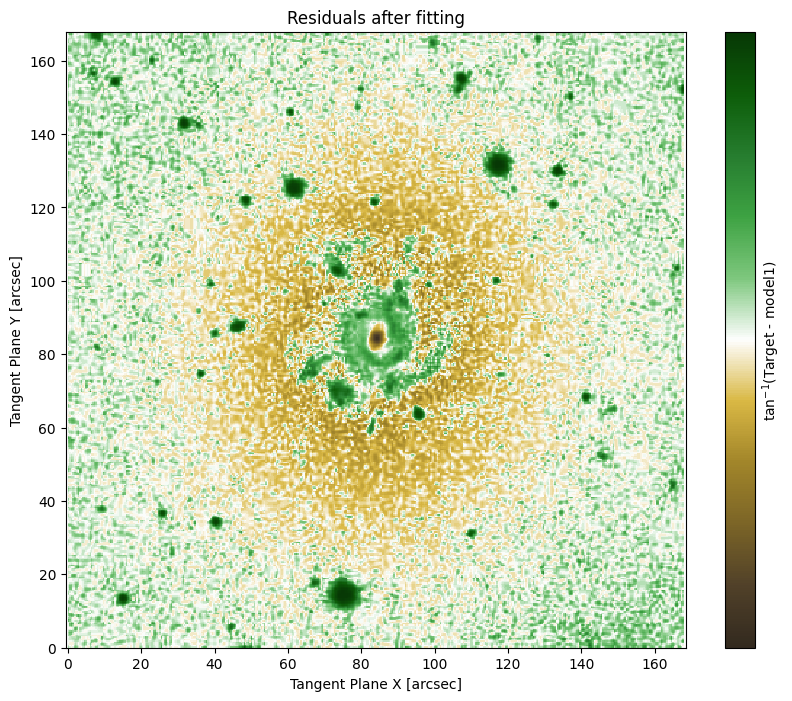

In [37]:
fig3, ax3 = plt.subplots(figsize = (10,8))
ap.plots.residual_image(fig3, ax3, model1)
plt.title("Residuals after fitting")
plt.show()

In [38]:
ap.image.target_image.Target_Image(data = target_data, pixelscale = 0.396)

image pixelscale: [[0.396 0.   ]
 [0.    0.396]] origin: [0. 0.] shape: [167.904 167.904] center: [83.952 83.952]
data: [[ 6.  3.  0. ... 12.  6.  1.]
 [ 4.  1.  0. ...  7.  1.  0.]
 [ 2.  0.  0. ...  3.  1.  2.]
 ...
 [ 1.  5.  7. ...  4.  4.  4.]
 [ 5. 12. 14. ...  4.  5.  6.]
 [13. 21. 21. ...  2.  4.  6.]]

Filename: galaxyZoo/fits_images/f_100373.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (424, 424)   uint8   


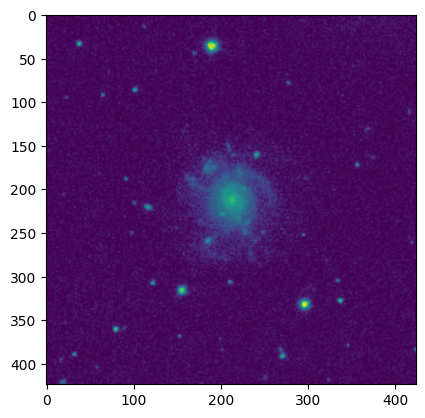

In [39]:
img_filename = "galaxyZoo/fits_images/f_100373.fits"
img_data = fits.getdata(img_filename, ext = 0)
# img_data = img_data.T
fits.info(img_filename)
plt.figure()
plt.imshow(img_data)